# Code

In [1]:
!pip install pymc3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from matplotlib.patches import Patch
from scipy.integrate import odeint
import pymc3 as pm

Data retrived from ref([1](https://doi.org/10.1038/s41591-021-01377-8)) using the web tool [WebPlotDigitalizer](https://apps.automeris.io/wpd/)

In [2]:
df = pd.DataFrame({'Vaccine': ['mRNA-1273', 'NVX-CoV2373', 'BNT162b2', 'rAd26-S + rAd5-S', 'Convalescent',
                               'ChAdOx1 nCoV-19', 'Ad26.COV2.S', 'CoronaVac'],
                   'Efficacy': [93.5, 95.3, 94.6, 91.2, 88.6, 61.6, 67.2, 50.3],
                   'Eff 95% up': [96.2, 98.9, 97, 94.6, 97.3, 75.3, 73.8, 61.6],
                   'Eff 95% down': [88.7, 67.7, 89.4, 85.1, 65.4, 40.5, 58.9, 35.6],
                   'IC_50': [4.16, 4.01, 2.39, 1.41, 1, 0.54, 0.47, 0.17],
                   'IC_50 up': [10.32, 9.51, 3.81, 2.59, 1.62, 1, 0.81, 0.26],
                   'IC_50 down': [1.7, 1.96, 1.5, 0.77, 0.62, 0.29, 0.27, 0.11]})

In [3]:
data = df.sort_values('IC_50', inplace=True)

X = np.array(df.loc[:, 'IC_50'])
Y = np.array(df.loc[:, 'Efficacy'])

N_SAMPLES = 50000

In [4]:
def logistic(x, beta, sigma):
    return 100 / (1.0 + np.exp(-np.dot(beta, x) + sigma))

def free_style(x, beta):
  return 100*x/(beta + x)

In [5]:
logistic_model = pm.Model()
new_model = pm.Model()

with logistic_model:

    # Priors for unknown model parameters
    alpha = pm.Uniform('alpha', 1, 5)
    beta = pm.Uniform('beta', 0, 1)

    # Expected value of outcome
    mu = 100/(1 + np.exp(-alpha*(X - beta)))

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, observed=Y)

    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    trace_logistic = pm.sample(N_SAMPLES, step=step)

with new_model:

    # Priors for unknown model parameters
    alpha = pm.Uniform('alpha', 0, 4)

    # Expected value of outcome
    mu = 100*X/(alpha + X)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, observed=Y)

    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    trace_new = pm.sample(N_SAMPLES, step=step)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 2 chains for 1_000 tune and 50_000 draw iterations (2_000 + 100_000 draws total) took 36 seconds.
The number of effective samples is smaller than 10% for some parameters.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Sequential sampling (2 chains in 1 job)
Metropolis: [alpha]


/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


Sampling 2 chains for 1_000 tune and 50_000 draw iterations (2_000 + 100_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


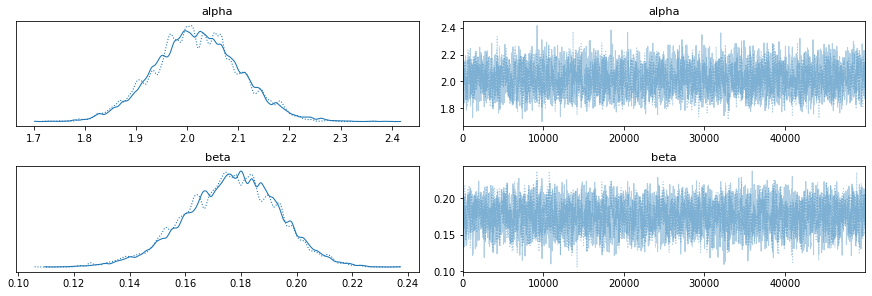

In [6]:
_ = pm.traceplot(trace_logistic)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


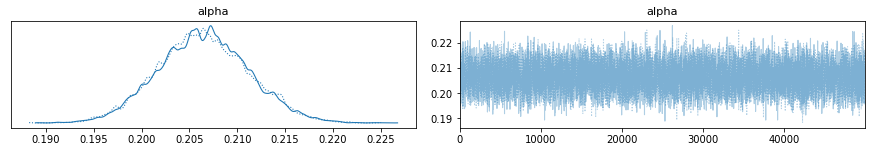

In [7]:
_ = pm.traceplot(trace_new)

In [8]:
# Extract the alpha and beta samples
alpha_samples_log = trace_logistic["alpha"][10000:, None]
beta_samples_log = trace_logistic["beta"][10000:, None]
alpha_samples_new = trace_new["alpha"][10000:, None]

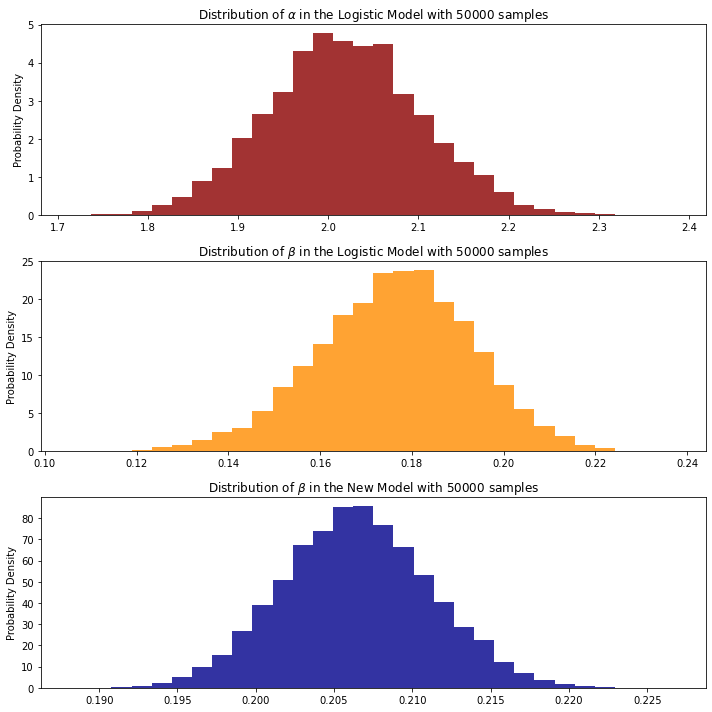

In [9]:
fig,ax = plt.subplots(3,1, figsize=(10,10))
ax[0].set_title(r"""Distribution of $\alpha$ in the Logistic Model with %d samples""" % N_SAMPLES)
ax[0].hist(alpha_samples_log, histtype='stepfilled', 
         color = 'darkred', bins=30, alpha=0.8, density=True);
ax[0].set_ylabel('Probability Density')

ax[1].set_title(r"""Distribution of $\beta$ in the Logistic Model with %d samples""" % N_SAMPLES)
ax[1].hist(beta_samples_log, histtype='stepfilled', 
         color = 'darkorange', bins=30, alpha=0.8, density=True)
ax[1].set_ylabel('Probability Density')

ax[2].set_title(r"""Distribution of $\beta$ in the New Model with %d samples""" % N_SAMPLES)
ax[2].hist(alpha_samples_new, histtype='stepfilled', 
         color = 'darkblue', bins=30, alpha=0.8, density=True)
ax[2].set_ylabel('Probability Density')

plt.tight_layout()

In [10]:
pm.summary(trace_logistic)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.019,0.084,1.865,2.183,0.002,0.001,3061.0,4791.0,1.0
beta,0.176,0.017,0.145,0.209,0.000,0.000,3005.0,4760.0,1.0


In [11]:
pm.summary(trace_new)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.206,0.005,0.198,0.216,0.0,0.0,11373.0,11952.0,1.0


In [13]:
# nabs values
nabs = np.linspace(0, 15, 1000)[:, None]

# Take most likely parameters to be mean values
alpha_est_log = alpha_samples_log.mean()
beta_est_log = beta_samples_log.mean()
alpha_est_new = alpha_samples_new.mean()

new_mod = free_style(nabs, alpha_est_new)
log_mod = logistic(nabs, alpha_est_log, beta_est_log)

In [14]:
print(f"R^2 free-style: {r2_score(free_style(df['IC_50'], alpha_est_new), df['Efficacy'])}")
print(f"R^2 logistic: {r2_score(logistic(df['IC_50'], alpha_est_log, beta_est_log), df['Efficacy'])}")

R^2 free-style: 0.8999545788350283
R^2 logistic: 0.9030555864123297


In [15]:
new_alpha_low = pm.summary(trace_new)['hdi_3%']['alpha']
new_alpha_up = pm.summary(trace_new)['hdi_97%']['alpha']
log_alpha_low = pm.summary(trace_logistic)['hdi_3%']['alpha']
log_alpha_up = pm.summary(trace_logistic)['hdi_97%']['alpha']
log_beta_up = pm.summary(trace_logistic)['hdi_97%']['beta']
log_beta_low = pm.summary(trace_logistic)['hdi_3%']['beta']

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/pyth

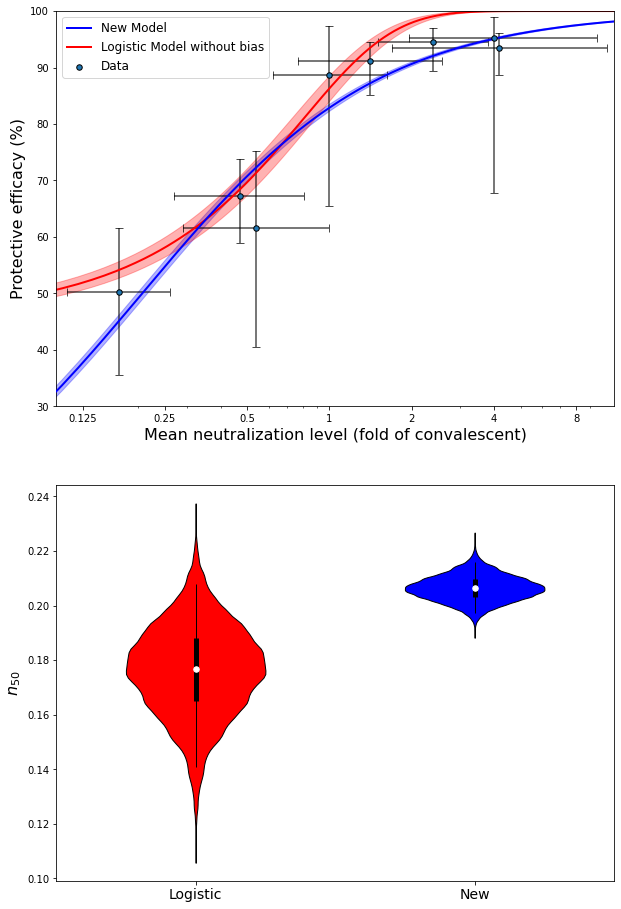

In [19]:
fig, ax = plt.subplots(2,1, figsize=(10,16))
ax[0].errorbar(df['IC_50'], df['Efficacy'], yerr=[df['Efficacy']-df['Eff 95% down'],
                                                df['Eff 95% up']-df['Efficacy']], xerr = [df['IC_50']-df['IC_50 down'],
                                                                                          df['IC_50 up']-df['IC_50']], fmt = 'none',
             color = 'black', capsize = 4, alpha = 0.7)
ax[0].scatter(X, Y, edgecolor = 'black',
            s=30, alpha=1, label='Data', zorder=5)
ax[0].plot(nabs, new_mod, color = 'blue', 
         lw=2, label="New Model", zorder = 4)
ax[0].fill_between(nabs.flatten(), free_style(nabs, new_alpha_low).flatten(), free_style(nabs, new_alpha_up).flatten(),
                 color = 'blue', alpha = 0.3)
ax[0].plot(nabs, log_mod, color = 'red', 
         lw=2, label="Logistic Model without bias")
ax[0].fill_between(nabs.flatten(), logistic(nabs, log_alpha_low, log_beta_up).flatten(), logistic(nabs, log_alpha_up, log_beta_low).flatten(),
                 color = 'red', alpha = 0.3)
ax[0].legend(loc = 'upper left', prop={'size':12})
ax[0].set_ylabel('Protective efficacy (%)', fontsize = 16)
ax[0].set_xlabel('Mean neutralization level (fold of convalescent)', fontsize = 16)
ax[0].set_xscale('log')
ax[0].set_xticks([0.125, 0.25, 0.5, 1, 2, 4, 8])
ax[0].set_xticklabels(labels = ['0.125', '0.25', '0.5', '1', '2', '4', '8'])
ax[0].set_xlim(0.1,11)
ax[0].set_ylim(30,100)

parts = ax[1].violinplot(beta_samples_log, showmeans=False, showextrema = False, showmedians=False,
                         positions = [1])
for pc in parts['bodies']:
    pc.set_facecolor('red')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
quartile1, medians, quartile3 = np.percentile(beta_samples_log, [25, 50, 75])
whiskers_min, whiskers_max = np.percentile(beta_samples_log, [2.5, 97.5])
ax[1].scatter(1, medians, marker='o', color='white', s=30, zorder=3)
ax[1].vlines(1, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax[1].vlines(1, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

parts2 = ax[1].violinplot(alpha_samples_new, showmeans=False, showextrema = False, showmedians=False,
                          positions = [2])
for pc in parts2['bodies']:
    pc.set_facecolor('blue')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
quartile1, medians, quartile3 = np.percentile(alpha_samples_new, [25, 50, 75])
whiskers_min, whiskers_max = np.percentile(alpha_samples_new, [2.5, 97.5])
ax[1].scatter(2, medians, marker='o', color='white', s=30, zorder=3)
ax[1].vlines(2, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax[1].vlines(2, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

ax[1].set_ylabel(r'$n_{50}$', fontsize = 16)
ax[1].set_xticks([1,2])
ax[1].set_xticklabels(labels=['Logistic', 'New'], fontsize = 14)
ax[1].set_xlim(0.5,2.5)

plt.savefig('Models_vaccines.png', dpi = 300, bbox_inches = 'tight')

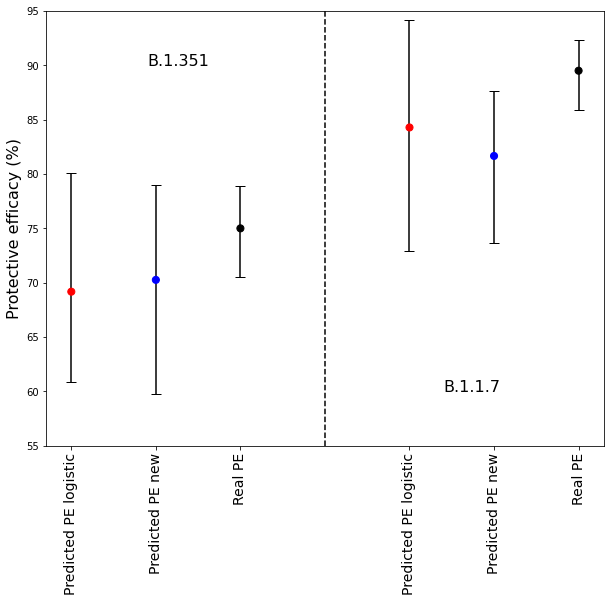

In [20]:
plt.figure(figsize=(10,8))
plt.scatter([0,1,2,4,5,6], [logistic(2.39/4.9, alpha_est_log, beta_est_log), free_style(2.39/4.9, alpha_est_new), 75,
                        logistic(2.39/2.6, alpha_est_log, beta_est_log), free_style(2.39/2.6, alpha_est_new), 89.5],
        color = ['red', 'blue', 'black', 'red', 'blue', 'black'], zorder = 1, s = 50)
plt.errorbar([0,1,2,4,5,6], [logistic(2.39/4.9, alpha_est_log, beta_est_log), free_style(2.39/4.9, alpha_est_new), 75,
                        logistic(2.39/2.6, alpha_est_log, beta_est_log), free_style(2.39/2.6, alpha_est_new), 89.5],
             yerr= [[logistic(2.39/4.9, alpha_est_log, beta_est_log)-logistic(1.5/4.9, alpha_est_log, beta_est_log),
                     free_style(2.39/4.9, alpha_est_new)-free_style(1.5/4.9, alpha_est_new),
                     75-70.5,logistic(2.39/2.6, alpha_est_log, beta_est_log)-logistic(1.5/2.6, alpha_est_log, beta_est_log),
                     free_style(2.39/2.6, alpha_est_new)-free_style(1.5/2.6, alpha_est_new),89.5-85.9],
                    [logistic(3.81/4.9, alpha_est_log, beta_est_log)-logistic(2.39/4.9, alpha_est_log, beta_est_log),
                     free_style(3.81/4.9, alpha_est_new)-free_style(2.39/4.9, alpha_est_new),
                     78.9-75,logistic(3.81/2.6, alpha_est_log, beta_est_log)-logistic(2.39/2.6, alpha_est_log, beta_est_log),
                     free_style(3.81/2.6, alpha_est_new)-free_style(2.39/2.6, alpha_est_new),92.3-89.5]],
             fmt = 'none', color = 'black', capsize = 5, zorder = 0)
plt.ylabel('Protective efficacy (%)', fontsize = 16)
plt.xticks([0,1,2,4,5,6], labels = ['Predicted PE logistic', 'Predicted PE new', 'Real PE',
                                    'Predicted PE logistic', 'Predicted PE new', 'Real PE'], fontsize = 14, rotation = 90)
plt.ylim(55,95)
plt.vlines(3,55,95, linestyles='dashed')
plt.text(0.9,90,'B.1.351', fontsize = 16)
plt.text(4.4,60,'B.1.1.7', fontsize = 16)
plt.savefig('PE_predictions.png', dpi = 300, bbox_inches = 'tight')

# References

1. Khoury, D. S., Cromer, D., Reynaldi, A., Schlub, T. E., Wheatley, A. K., Juno, J. A., ... & Davenport, M. P. (2021). Neutralizing antibody levels are highly predictive of immune protection from symptomatic SARS-CoV-2 infection. Nature medicine, 1-7. [https://doi.org/10.1038/s41591-021-01377-8](https://doi.org/10.1038/s41591-021-01377-8)